In [1]:
import sys
from pathlib import Path


In [2]:
module_path = Path.cwd().parent.parent
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [3]:
import pickle
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")
plt.style.use("seaborn")


/tmp/ipykernel_3666/1181581837.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [5]:
from src.loader import TextLoader
from src.visualizer import Visualizer
from src.model import DatasetType


In [6]:
text_loader = TextLoader()
visualizer = Visualizer()

<center> <h2> Discourse overview

In [7]:
DATA_DIR = Path.cwd() / "data"
DISCOURSE_POSITIONS = DATA_DIR / "discourse_positions.pkl"


In [8]:
if not DISCOURSE_POSITIONS.exists():
    discourse_positions = []
    for text_id in text_loader:
        text = text_loader.load_text_with_id(text_id)
        for discourse in text.discourses:
            discourse_positions.append(
                [
                    discourse.type.value,
                    discourse.ind_start / len(text) * 100,
                    discourse.ind_end / len(text) * 100,
                ]
            )

    pickle.dump(discourse_positions, open(DISCOURSE_POSITIONS, "wb"))


In [9]:
discourse_positions: list[list[str, float, float]] = pickle.load(open(DISCOURSE_POSITIONS, "rb"))


In [10]:
discourse_type = text_loader.df["discourse_type"].value_counts()
types, count = discourse_type.index, discourse_type.values


In [13]:
discourse_type

Claim                   50197
Evidence                45691
Position                15415
Concluding Statement    13503
Lead                     9303
Counterclaim             5813
Rebuttal                 4334
Name: discourse_type, dtype: int64

In [14]:
discourse_type.sum()

144256

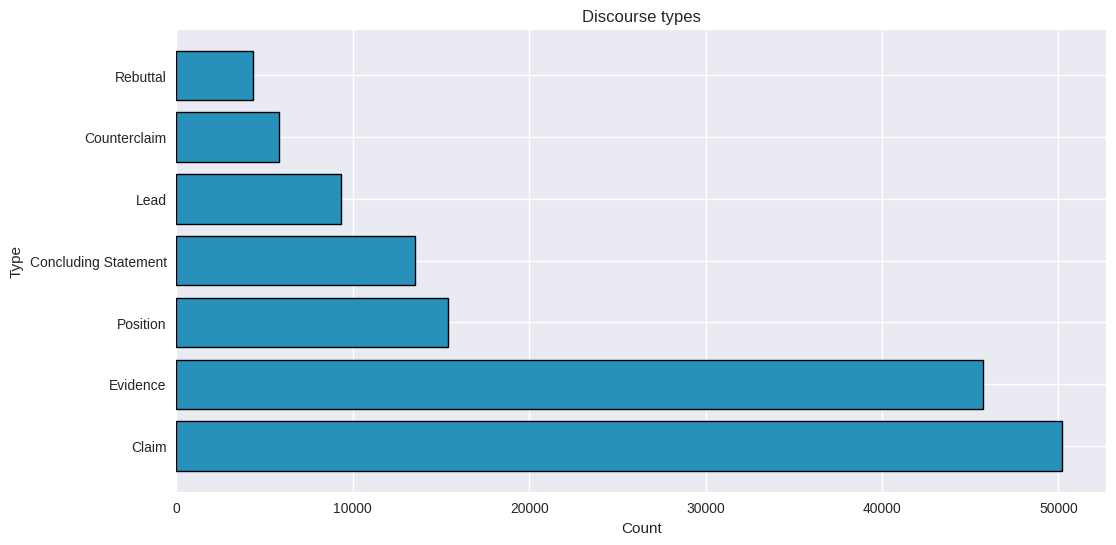

In [10]:
# Histogram of discourse types
plt.figure(figsize=(12, 6))
plt.barh(types, count, edgecolor="black", linewidth=1, color="#2791bc")
plt.title("Discourse types")
plt.xlabel("Count")
plt.ylabel("Type")
plt.show()


In [11]:
df = pd.DataFrame(discourse_positions, columns=["type", "start", "end"])
df


,type,start,end
0,Lead,0.394089,11.280788
1,Position,11.330049,15.369458
2,Evidence,15.418719,19.753695
3,Evidence,19.802956,37.339901
4,Claim,37.389163,43.645320
...,...,...,...
144288,Evidence,38.006125,54.491324
144289,Evidence,54.797550,76.709765
144290,Position,76.726778,77.747533
144291,Evidence,77.747533,83.735965


In [12]:
dd = pd.melt(
    df, id_vars=["type"], value_vars=["start", "end"], var_name="position", value_name="text_perc"
)
dd


,type,position,text_perc
0,Lead,start,0.394089
1,Position,start,11.330049
2,Evidence,start,15.418719
3,Evidence,start,19.802956
4,Claim,start,37.389163
...,...,...,...
288581,Evidence,end,54.491324
288582,Evidence,end,76.709765
288583,Position,end,77.747533
288584,Evidence,end,83.735965


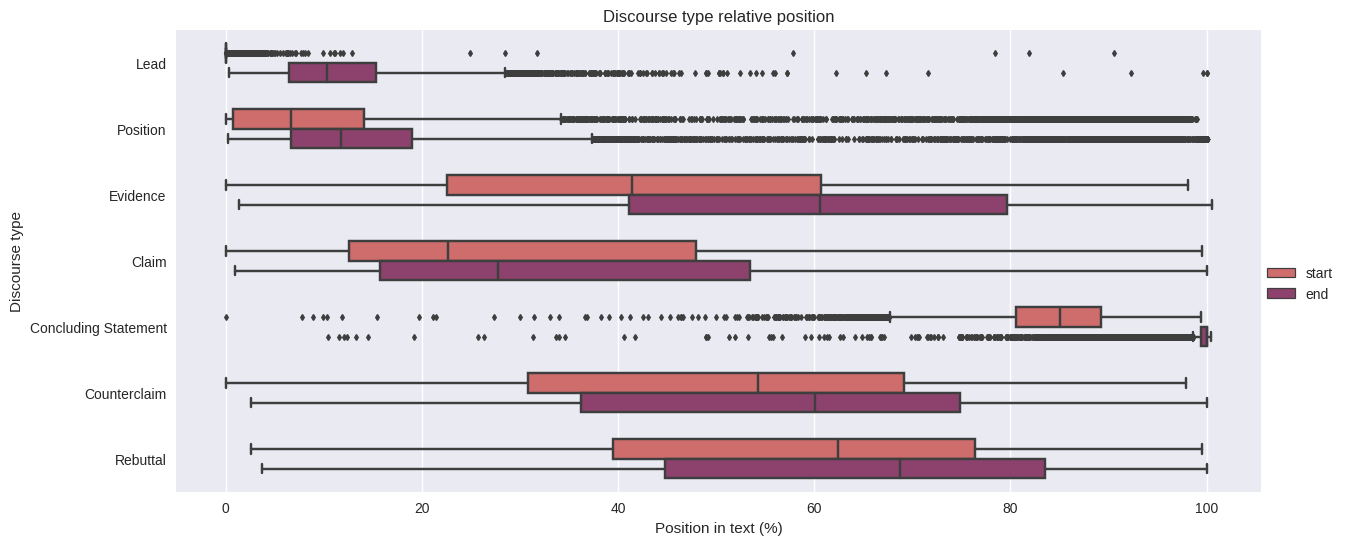

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    x="text_perc", y="type", hue="position", data=dd, width=0.6, fliersize=3, palette="flare"
).set(title="Discourse type relative position", xlabel="Position in text (%)", ylabel="Discourse type")
plt.legend(bbox_to_anchor=(1, 0.5), loc="upper left", borderaxespad=0)
plt.show()


In [14]:
# Check if any discourse starts in the middle of another discourse
def is_discourse_overlap() -> bool:
    return False  # For now so that the cell is not evaluated every time
    for text_id in text_loader:
        text = text_loader.load_text_with_id(text_id)
        for discourse in text.discourses:
            for other_discourse in text.discourses:
                if discourse == other_discourse:
                    continue

                if (
                    discourse.ind_start > other_discourse.ind_start
                    and discourse.ind_start < other_discourse.ind_end
                ):
                    print(
                        f"Discourse {discourse.type.value} starts in the middle of discourse {other_discourse.type.value} in text {text_id}"
                    )
                    return True

    return False


In [15]:
print(f"Discourse overlap: {is_discourse_overlap()}")


Discourse overlap: False


<center> <h2> Outliers

In [16]:
all_stats = {}
for text_id in text_loader:
    text = text_loader.load_text_with_id(text_id)
    all_stats[text] = round(text.gap_len / len(text) * 100, 4)

all_stats = {k: v for k, v in sorted(all_stats.items(), key=lambda item: item[1], reverse=True)}


15594 / 15594


In [17]:
counter = 0
threshold = 20
for ind, (text, ratio) in enumerate(all_stats.items()):
    if ratio < threshold:
        break
    counter += 1
    if ind < 5:
        print(f"{text.id}: {ratio:.4f}% out of {len(text)}")

print(f"\nDocuments with unclassified text percentage >= {threshold}%:")
print(f"{counter} out of {len(text_loader)} ({counter / len(text_loader) * 100:.2f}%)")


C278EDC82048: 91.9401% out of 8015
129497C3E0FC: 91.5679% out of 3629
F5EE08CB44B9: 90.8196% out of 3148
9B23715DFB32: 89.8428% out of 18322
F45B396E0A01: 88.9246% out of 1869

Documents with unclassified text percentage >= 20%:
898 out of 15594 (5.76%)


In [18]:
outlier = text_loader.load_text_with_id("C278EDC82048")


In [19]:
outlier.non_classified_parts

[(126, 135), (160, 164), (225, 226), (243, 249), (277, 278), (667, 8015)]

In [20]:
print(outlier.info)
print(f"Gap length: {outlier.gap_len}")

Text id: C278EDC82048; Length: 8015; Discourses: 8
Gap length: 7369


In [21]:
visualizer.visualize_text(outlier)